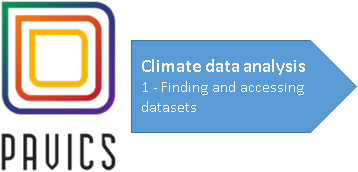
<a id='top1'></a>

PAVICS climate <a href="/datasets.html" target="_blank">datasets<a /> are hosted on a <a href="https://www.unidata.ucar.edu/software/tds/current/" target="_blank">THREDDS data server</a> at <a href="https://pavics.ouranos.ca/thredds" target="_blank">https://pavics.ouranos.ca/thredds</a>. Although THREDDS provides a user-interface for browsing datasets, it is often more practical to  navigate the catalogue programatically.  The tutorial introduces the <a href="https://unidata.github.io/siphon/latest/index.html" target="_blank">siphon</a> library to browse the THREDDS catalog, and <a href="http://xarray.pydata.org/en/stable/index.html" target="_blank">xarray</a> to open a streaming connection to the remote data.
    
More specifically, the tutorial demonstrates how to access an ensemble of climate simulations, namely Ouranos' standard ensemble of bias-adjusted climate scenarios version 1.0 (cb-oura-1.0), using python commands. The ensemble contains <a href="https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.html" target="_blank">22 bias-adjusted CMIP5 simulations</a> in netCDF format, each with three variables (tasmin, tasmax, pr) and dimensions of longitude, latitude and time (1064, 700, 55175). The server can provide multiple <a href="https://www.unidata.ucar.edu/software/tds/current/reference/Services.html#dataAccessServices" target="_blank"> data access</a> and <a href="https://www.unidata.ucar.edu/software/tds/current/reference/Services.html#metadataServices" target="_blank"> metadata services</a> but in the following steps the tutorial will focus on the *OPeNDAP* service, where instead of downloading huge volumes of data locally, only the relevant portion is accessed using a standard called Data Access Protocol (DAP).


<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

In [1]:
from siphon.catalog import TDSCatalog

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"  # TEST_USE_PROD_DATA

# Create Catalog
cat = TDSCatalog(url)

# List of datasets
print(f"Number of datasets: {len(cat.datasets)}")

# Access mechanisms - here we are interested in OPENDAP, a data streaming protocol
cds = cat.datasets[0]
print(f"Access URLs: {tuple(cds.access_urls.keys())}")

Number of datasets: 22
Access URLs: ('HTTPServer', 'OPENDAP', 'NCML', 'UDDC', 'ISO', 'WCS', 'WMS', 'NetcdfSubset')


In [2]:
# NBVAL_IGNORE_OUTPUT

import xarray as xr

# This does not download the entire dataset, just the metadata and attributes describing the content.
ds = xr.open_dataset(cds.access_urls["OPENDAP"], chunks="auto")

# What we see here is an in-memory representation of the full content, the actual data is still on the server.
ds

<xarray.Dataset>
Dimensions:  (lat: 320, lon: 797, time: 55115)
Coordinates:
  * lat      (lat) float32 66.62 66.54 66.46 66.37 ... 40.29 40.21 40.12 40.04
  * lon      (lon) float32 -120.8 -120.7 -120.6 -120.5 ... -54.63 -54.55 -54.46
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(7534, 42, 106), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(7534, 42, 106), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(7534, 42, 106), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    driving_model:              NorESM1-M
    ...                         ...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC

In [3]:
# Extract a subset of the file

# Again, this only creates an in-memory representation of the data
sub = ds.pr.sel(time="2050").sel(lon=-80, lat=46, method="nearest")

# The data is only downloaded when we actuall need it for a computation.
sub.mean(keep_attrs=True).compute()

<xarray.DataArray 'pr' ()>
array(3.975487e-05, dtype=float32)
Coordinates:
    lat      float32 46.04
    lon      float32 -79.96
Attributes:
    long_name:      lwe_precipitation_rate
    standard_name:  lwe_precipitation_rate
    units:          mm s-1
    _ChunkSizes:    [256  16  16]

### Filtering datasets based on filename name

Upcoming versions of PAVICS will include a data catalog faciliting queries for simulations that meet certain criteria (model, GHG emission scenario, variable, etc). For now, one simple way to filter datasets if to look for patterns in their filename. For example, the following shows how to get all simulations driven by GHG emission scenario RCP 4.5.
<div class="alert alert-info">
<strong>Info!</strong> PAVICS <a href="/datasets.html" target='_blank'>datasets</a> are often provided via user-friendly <a href=#ncml>NetCDF Markup Language (NcML) aggregations</a> a convenient way to combine multiple files into a single, logical dataset. 
</div>

*[return to top of page](#top)*

In [4]:
rcp45_data = [cat.datasets[x] for x in cat.datasets if "rcp45" in x]
rcp45_data

[day_NorESM1-M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_MPI-ESM-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5B-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5A-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_INM-CM4_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_HadGEM2-CC_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_GFDL-ESM2M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CanESM2_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CMCC-CMS_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_BNU-ESM_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_ACCESS1-3_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml]

___
### Advanced example  
* Create a python dictionary separating the various RCP 4.5 & RCP 8.5 simulations in the ensemble
* Validate that the search is finding an expected number of simulations for each RCP (n=11 in this case)


*[return to top of page](#top)*

In [5]:
# create a simple search sub-function
def get_ncfilelist(pattern, expected, url):
    cat = TDSCatalog(url)
    ## crawl a thredds catalog and filter results for dataset names containing a string pattern
    ncfiles = [
        cat.datasets[x] for x in cat.datasets if pattern in x
    ]  # list of all datasets

    ## Validate that the number of results is equal to the provided expected number
    if len(ncfiles) == expected:
        display(f"Successfully found {expected} datasets for {pattern}")
        return ncfiles
    else:
        raise ValueError(
            f"Expected number of datasets for {pattern} is {expected} : found {len(ncfiles)}"
        )

In [6]:
datasets = {}
for r in ["rcp45", "rcp85"]:
    expected = 11
    datasets[r] = get_ncfilelist(r, expected, url)

# Display search results
display(datasets["rcp45"])
display(datasets["rcp85"])

'Successfully found 11 datasets for rcp45'

'Successfully found 11 datasets for rcp85'

[day_NorESM1-M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_MPI-ESM-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5B-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5A-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_INM-CM4_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_HadGEM2-CC_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_GFDL-ESM2M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CanESM2_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CMCC-CMS_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_BNU-ESM_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_ACCESS1-3_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml]

[day_NorESM1-M_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_MPI-ESM-LR_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5B-LR_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_IPSL-CM5A-LR_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_INM-CM4_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_HadGEM2-CC_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_GFDL-ESM2M_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CanESM2_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_CMCC-CMS_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_BNU-ESM_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml,
 day_ACCESS1-3_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml]

___
### Notes
<a id='ncml'></a>
<div class="alert alert-info">
<strong>Info!</strong>  <a href=https://www.unidata.ucar.edu/software/netcdf-java/v4.6/ncml/index.htm target='_blank'>NetCDF Markup Language (NcML)</a>: PAVICS datasets are often provided via user-friendly NcML aggregations, a convenient way to combine multiple files into a single, logical dataset. For example, the particular catalog used in this tutorial accesses 22 climate datasets, where each simulation consists of a NcML aggregation. From a user's standpoint each cb-oura-1.0 simulation is accessible as a single .ncml, where in reality it consists of an aggregation of individual yearly netcdf files for each of the three variables (tasmin, tasmax, pr) over the period 1950-2100. 
</div>  


<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

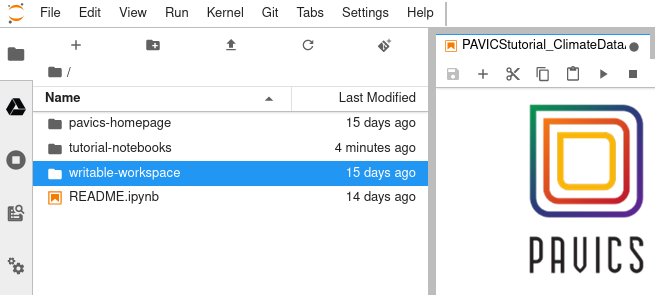

*[return to top of page](#top1)*